In [4]:
import numpy as np
import sys
import os
sys.path.append(os.environ.get('OTF')+'/otf_engine')
import gp, env, struc, kernels, otf, md, md_run
sys.path.append(os.environ.get('OTF')+'/modules')
import qe_parsers, analyze_gp, eam, analyze_md, otf_parser, analyze_otf, old_otf_parser
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import copy

In [5]:
# set font size
plt.rcParams.update(plt.rcParamsDefault)
font = {'size'   : 12}
plt.rc('font', **font)

# Analyze slab run

In [9]:
otf_file = \
    '/Users/jonpvandermause/Research/GP/data/OTF_Slabs/Al_Slab_BigSig_2-27/otf_run.out'

otf_obj = old_otf_parser.OtfAnalysis(otf_file)

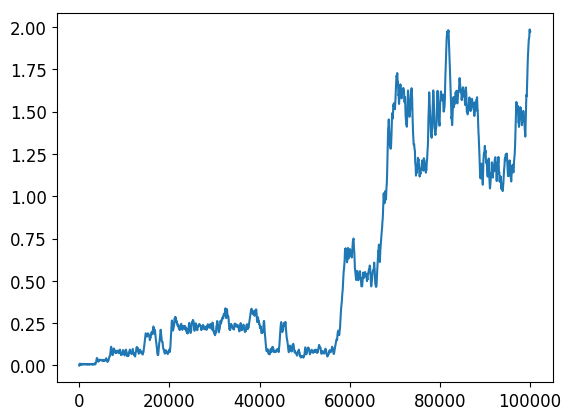

In [10]:
plt.plot(otf_obj.msds)
plt.show()

# Fig. 1 temperature

In [8]:
# collect otf data
otf_file = '/Users/jonpvandermause/Research/GP/data/Al_Temperature_Ramp/Al_Ramp_3-26/otf_run.out'
base_str = '/Users/jonpvandermause/Research/GP/data/Al_Temperature_Ramp/'

# otf_file = '/Users/jonpvandermause/Research/GP/data/Al_Temperature_Ramp/Al_Ramp_3-26/otf_run.out'


dft_times = np.load(base_str+'dft_times.npy')
dft_frames = np.load(base_str+'dft_frames.npy')
atom_count = np.load(base_str+'atom_count.npy')
temperatures = np.load(base_str+'temperatures.npy')
msds = np.load(base_str+'msds.npy')
times = np.load(base_str+'times.npy')
uncertainties = np.load(base_str+'uncertainties.npy')
dft_forces = np.load(base_str+'dft_forces.npy')
gp_forces = np.load(base_str+'gp_forces.npy')

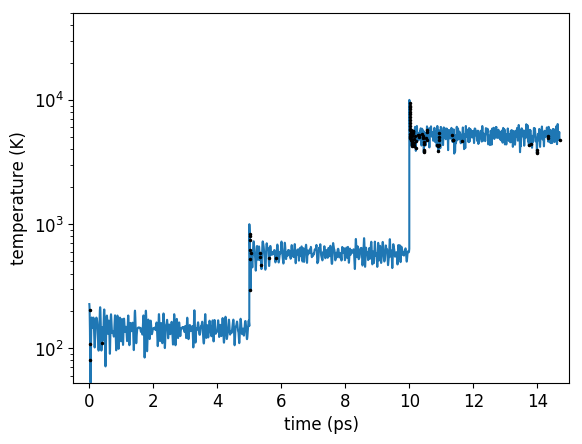

In [26]:
# plot temperature on a log scale
dft_temps = [temperatures[n-1] for n in dft_frames[1:]]  # exclude first call

plt.plot(times, temperatures)
plt.plot(dft_times[1:], dft_temps, 'k.', MarkerSize=3)
plt.yscale('log')
plt.xlabel('time (ps)')
plt.ylabel('temperature (K)')
plt.xlim(-0.5, 15)
plt.ylim(0, 50000)

plt.show()

# Fig. 1 learning curve

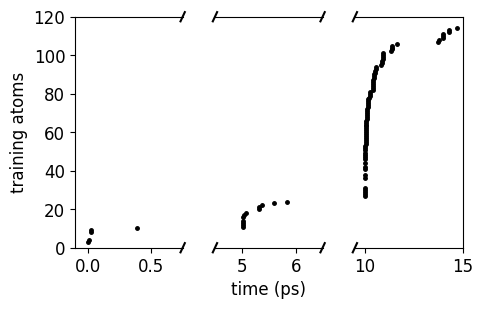

In [45]:
x = dft_times
y = np.cumsum(atom_count)

f,(ax,ax2,ax3) = plt.subplots(1,3,sharey=False, facecolor='w')

# plot the same data on both axes
msize = 5
ax.plot(x, y, 'k.', MarkerSize=msize)
ax2.plot(x, y, 'k.', MarkerSize=msize)
ax3.plot(x, y, 'k.', MarkerSize=msize)

ax.set_xlim(-0.1,0.75)
ax2.set_xlim(4.5, 6.5)
ax3.set_xlim(9.5, 15)

ax.set_ylim(0, 120)
ax2.set_ylim(0, 120)
ax3.set_ylim(0, 120)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

ax.yaxis.tick_left()
ax2.yaxis.set_major_locator(plt.NullLocator())
ax3.yaxis.set_major_locator(plt.NullLocator())


d = .02
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs)
ax2.plot((1-d,1+d),(-d,d), **kwargs)

kwargs.update(transform=ax3.transAxes)
ax3.plot((-d,+d), (1-d,1+d), **kwargs)
ax3.plot((-d,+d), (-d,+d), **kwargs)

f.subplots_adjust(wspace=0.3)
ax2.set_xlabel('time (ps)')
ax.set_ylabel('training atoms')

f.set_size_inches(5, 3)
plt.show()

In [52]:
dft_frames[0:17]

array([   0,   10,   25,   29,  388, 5012, 5013, 5015, 5019, 5022, 5035,
       5068, 5319, 5325, 5371, 5605, 5834])

# Fig. 1 Error